In [148]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Exercise 55

5.1 Classification: 1D case

This exercise is about learning to make classification with a neural network. 
To make things simple, it deals with a 1-dimensional descriptor space. 
I.e. every data is described by one coordinate, x. 
The data will be characterized by one of three labels: 0, 1, or 2.

5.2 Model predicting weights

a) Make a linear model that takes one input, and outputs 3 values


In [149]:
class LinModel(torch.nn.Module):
    def __init__(self, n_features=1, n_classes=3):
        """
        Initializes the LinModel.
        
        Args:
            n_features (int): The number of input features.
            n_classes (int): The number of output classes (or dimensions).
        """
        super().__init__()
        # Define a single linear layer (fc1)
        # Maps 'n_features' input features to 'n_classes' output logits
        self.fc1 = torch.nn.Linear(n_features, n_classes)
        
    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, n_features).
        
        Returns:
            torch.Tensor: Output logits of shape (batch_size, n_classes).
        """
        # Pass the input through the linear layer
        return self.fc1(x)

In [150]:
# Instantiate the LinModel with 1 input feature and 3 output classes
model = LinModel(n_features=1, n_classes=3)

# Input tensor: A single sample with 1 feature (batch size of 1)
x = torch.tensor([[2.0]])

# Perform a forward pass through the model
y = model(x)

# Print the input and the output logits
print("Input:", x)  # Input to the model
print("Output:", y)  # Output logits for 3 classes

# Loop through the model's parameters (weights and biases)
for name, parameter in model.named_parameters():
    # Print the name of the parameter and its current values
    print(name, '=', parameter.data)


Input: tensor([[2.]])
Output: tensor([[0.9138, 1.1265, 1.9057]], grad_fn=<AddmmBackward0>)
fc1.weight = tensor([[0.3279],
        [0.3540],
        [0.9669]])
fc1.bias = tensor([ 0.2579,  0.4184, -0.0281])


b) Set the three weights in the model to 0.7, 0.25 and 0.9, respectively and the three biases to 1,−0.4, and 0.5

In [151]:
model = LinModel()
model.fc1.weight.data = torch.tensor([[0.7], [0.25], [0.9]]) 
model.fc1.bias.data = torch.tensor([1, -0.4, 0.5])

c) Check that the parameters are set correctly by obtaining them from the model and writing them out:

In [152]:
for name, parameters in model.named_parameters():
    print(name,parameters)

fc1.weight Parameter containing:
tensor([[0.7000],
        [0.2500],
        [0.9000]], requires_grad=True)
fc1.bias Parameter containing:
tensor([ 1.0000, -0.4000,  0.5000], requires_grad=True)


d) Setup a tensor, test_P, with seven 
x-values from 
−6 to 
6:



In [153]:
test_P = torch.arange(-6, 7, 2)
test_P = test_P.to(torch.float) # convert entries to float type
test_P = test_P.float().view(-1, 1) # reshapoe tensor to have correct dimensions
test_P

tensor([[-6.],
        [-4.],
        [-2.],
        [ 0.],
        [ 2.],
        [ 4.],
        [ 6.]])

e) Pass the tensor to the network and check that it predicts these weights:

In [154]:
predicted_weights = model(test_P)
predicted_weights

tensor([[-3.2000, -1.9000, -4.9000],
        [-1.8000, -1.4000, -3.1000],
        [-0.4000, -0.9000, -1.3000],
        [ 1.0000, -0.4000,  0.5000],
        [ 2.4000,  0.1000,  2.3000],
        [ 3.8000,  0.6000,  4.1000],
        [ 5.2000,  1.1000,  5.9000]], grad_fn=<AddmmBackward0>)

5.3 Softmax

f) Implement a function f_softmax according to:

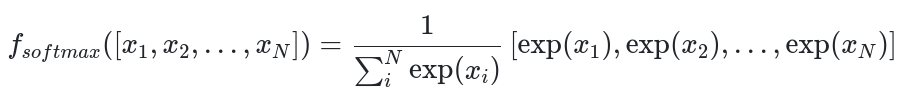

Hint: check that you get this output when applying your function to test_P:

In [155]:
def f(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)

# Compute softmax
predicted_probabilities = f(predicted_weights)
predicted_probabilities


tensor([[0.2061, 0.7562, 0.0377],
        [0.3617, 0.5397, 0.0986],
        [0.4967, 0.3013, 0.2020],
        [0.5396, 0.1331, 0.3273],
        [0.4987, 0.0500, 0.4513],
        [0.4183, 0.0171, 0.5646],
        [0.3300, 0.0055, 0.6645]], grad_fn=<DivBackward0>)

Note how the numbers in each row sum up to 1. They can thus be interpreted as probabilities for getting each of the three labels (e.g. 0, 1, or 2) for the independent variable, 
x_ 
i
​
 , corresponding to the 
i'th row.

g) Check that with the PyTorch-function torch.softmax you get the same probabilities:

In [156]:
dim = 1

pytorch_softmax = torch.softmax(predicted_weights,dim,dtype=None)
pytorch_softmax

if np.allclose(predicted_probabilities.detach().numpy(), pytorch_softmax.detach().numpy(), rtol=1e-05, atol=1e-08, equal_nan=False):
    print("The two tensors are equal, i.e. the softmax functions are the same!")


The two tensors are equal, i.e. the softmax functions are the same!


5.4 Cross-entropy

Our network is not trained yet, and its weights that we just turned into probabilities using softmax are basically just random. Nonetheless, call the probability distribution that the network codes for: 
Q. Later in this exercise, we will have some observations, that stem from another distribution, 
P, and minimizing the cross-entropy, 
H(P,Q), by optimizing the model parameters will lead to the neural network model learning to provide weights that code for 
P. However, we start by asking the question:

What are, according to 
Q, the most likely observations for 
x
∈
{
x
1
,
x
2
,
…
,
x
N
} ?

To answer that, consider the cross-entropy between the two distributions which is given by:

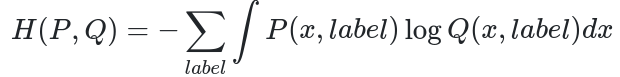

where 
x is the independent variable, and 
l
a
b
e
l
label runs over the three possible values (e.g. 0, 1, and 2).

Our knowledge about the distribution P comes via N observations: {(x1,label_1),(x2,label_2),...,(x_N,label_N)}, where for now we ask what the most likely labels are? With P known via observations, the cross-entropy is given by:

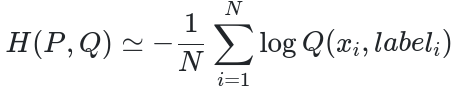

h) Minimize H(P,Q) with respect o {label1, label2,...label_N} for [x1,x2,...x_N]=test_P.

Hint 1: Write a code like this:

Loop a finite number of times

- guess N random labels

- evaluate the cross-entropy with those N guessed observations

- print out the value of the cross-entropy and the guessed observations if they give the smallest cross-entropy seen so far.

Hint 2: Complete this function for evaluating the cross-entropy:

In [157]:
def cross_entropy_from_probabilities(probabilities, guessed_labels):
    # Gather the probabilities corresponding to the guessed labels
    probabilities_for_guessed_labels = torch.gather(probabilities,
                                                    dim=1,
                                                    index=guessed_labels.unsqueeze(1))
    return -torch.mean(torch.log(probabilities_for_guessed_labels))

In [173]:
import random

# Convert logits to probabilities using softmax
Q = torch.softmax(predicted_weights, dim=1)

# Number of samples (N) and classes (C)
N, C = Q.shape

# Function to compute cross-entropy
def compute_cross_entropy(probabilities, guessed_labels):
    probabilities_for_guessed_labels = torch.gather(probabilities, dim=1, index=guessed_labels.unsqueeze(1))
    return -torch.mean(torch.log(probabilities_for_guessed_labels))

# Initialize the smallest cross-entropy and best labels
smallest_cross_entropy = float('inf')
best_labels = None

# Loop a finite number of times
for _ in range(100):  # Number of random guesses
    # Generate N random labels (one for each sample)
    guessed_labels = torch.tensor([random.randint(0, C - 1) for _ in range(N)])

    # Evaluate cross-entropy for the guessed labels
    cross_entropy = compute_cross_entropy(Q, guessed_labels)

    # Update the smallest cross-entropy and best labels
    if cross_entropy < smallest_cross_entropy:
        smallest_cross_entropy = cross_entropy
        best_labels = guessed_labels

        # Print the current smallest cross-entropy and corresponding labels
        print(f"{smallest_cross_entropy.item()} {best_labels}")


1.869808554649353 tensor([0, 2, 2, 2, 0, 2, 1])
1.1840944290161133 tensor([0, 1, 1, 0, 1, 0, 2])
0.9840943217277527 tensor([0, 1, 2, 0, 2, 2, 0])
0.741237223148346 tensor([1, 0, 2, 0, 0, 2, 2])
0.5698086619377136 tensor([1, 1, 0, 0, 2, 2, 2])


i) Now that you have implemented cross-entropy yourself, it is time to use the cross-entropy function implemented in PyTorch. For reasons of efficiency, the PyTorch class implementing cross-entropy in PyTorch takes the raw output weights of the neural network as input (i.e. not the probabilities after applying the softmax). Hint: Complete this code:

In [174]:
criterion = torch.nn.CrossEntropyLoss()
criterion(predicted_weights, torch.tensor([1, 1, 0, 0, 0, 2, 2], dtype=torch.long))

tensor(0.5555, grad_fn=<NllLossBackward0>)

5.5 Model predictions of label

In the last question, you varied the possibly observed labels in order to minimize the cross-entropy for a fixed model. This led to the most likely observed labels. But honestly, those labels can be obtained in a much easier way: You can simply find the label with the largest predicted probability for each input, 
x_i.

j) Extend the model with a method to predict the labels.

(Use argmax)

In [175]:
# Define the predict_label function
def predict_label(self, x):
    # Perform a forward pass to get logits
    logits = self.forward(x)
    # Apply softmax to convert logits to probabilities
    probabilities = torch.softmax(logits, dim=1)
    # Use argmax to find the index of the highest probability
    predicted_labels = torch.argmax(probabilities, dim=1)
    return predicted_labels

setattr(LinModel, "predict_label", predict_label) # attaching the new function to the LinModel class

k) Check that you get the same labels as in the cross-entropy optimization:

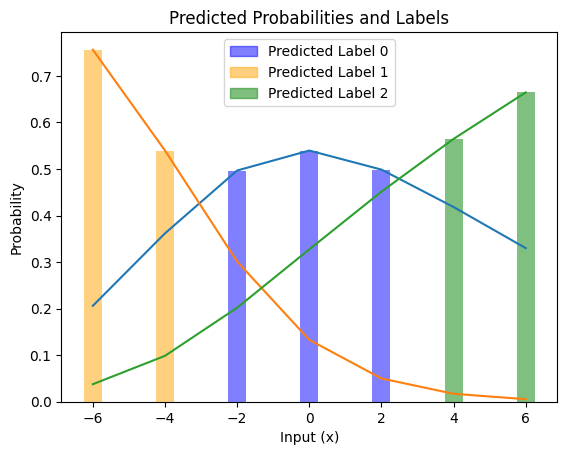

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Test data (inputs)
test_P = torch.tensor([[-6.0], [-4.0], [-2.0], [0.0], [2.0], [4.0], [6.0]])

# Get logits and probabilities from the model
logits = model(test_P)
probabilities = torch.softmax(logits, dim=1)  # Compute probabilities
predicted_labels = model.predict_label(test_P)  # Predicted labels

# Convert tensors to NumPy arrays for plotting
x = test_P.numpy().flatten()  # Inputs (x-axis values)
probabilities_np = probabilities.detach().numpy()  # Probabilities
predicted_labels_np = predicted_labels.numpy()  # Predicted labels

# Plot probability curves for each class
for class_idx in range(probabilities_np.shape[1]):
    plt.plot(x, probabilities_np[:, class_idx], label=f"Q_init(x, {class_idx})")

# Add bars for probabilities of predicted labels
colors = ['blue', 'orange', 'green']  # Colors for the classes
for i, x_val in enumerate(x):
    # Get the predicted label and its probability
    predicted_label = predicted_labels_np[i]
    probability = probabilities_np[i, predicted_label]
    # Plot a bar with the corresponding class color
    plt.bar(x_val, probability, width=0.5, alpha=0.5, color=colors[predicted_label])

# Add legend entries for bars
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.5, label=f"Predicted Label {class_idx}")
    for class_idx, color in enumerate(colors)
]
plt.legend(handles=handles)

# Add labels and title
plt.xlabel("Input (x)")
plt.ylabel("Probability")
plt.title("Predicted Probabilities and Labels")
plt.show()


and plot them (the heights of the bars are not so important):

Include in the plot three curves, 
Q_init(x,label), for the probabilities of the three different labels as predicted by the yet untrained neural network.

5.6 Optimize model
You have now worked with all the ingredients required to train a network for classification: weight-prediction, conversion to probabilities with softmax, and probability comparisons via cross-entropy. Now is time for introducing some data that will represent the probability distribution 
P
(
x
,
l
a
b
e
l
)
P(x,label).

l) Compose the data in this way:

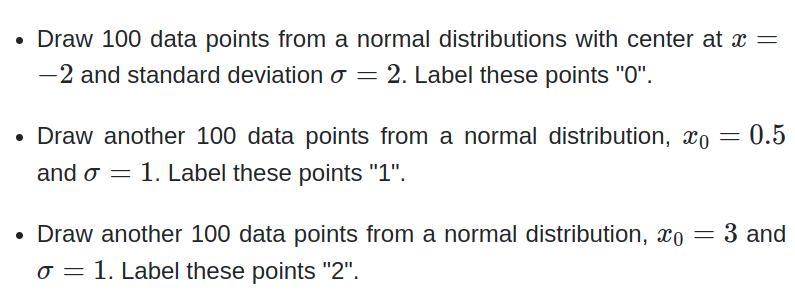

and plot it:

m) Predict and plot the labels for the training data with the untrained neural network:

Notice how wrong the initial, untrained network is in predicting the labels.

n) Use the cross-entropy as a loss-function in the optimization of the parameters of the neural network behind the probability density 
Q. Plot both the 
Q
(
x
,
l
a
b
e
l
) curves of the trained network and insert the label-predictions for all 
x-values in the training set.

In [163]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    ... = model( ...
    loss = ...
    loss.backward()
    optimizer.step()

SyntaxError: '(' was never closed (953069956.py, line 3)

o) Plot the two probabilities, 
P and Q, as you know them best. I.e. plot the data points for P that were used for the training, and plot the three probability curves, one for each label, according to the trained neural network, i.e. Q(x,label):